# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [14]:
! pip install torch torchvision torchsummary

## Download the data

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [0]:
train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

In [16]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [0]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
img_path = "./train/images/"
labels_path = "./train/annotations/"

In [18]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

### Data preprocessing

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
grayscale_images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    if len(current_img_vector.shape)==2: # If shape is (128, 128) (no color channels)
        filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
        img_num = filename_without_extension[2:] # drop the heading "im"
        grayscale_images+=[img_num]
del image_files

In [0]:
data=grayscale_images
labels = [[] for _ in range(len(data))] # Empty list of labels
annotations_path = "train/annotations/"
annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
        if os.path.isfile(os.path.join(annotations_path, f))]
for file in annotations_files:
    label = os.path.basename(file)[:-4] # :-4 to drop the extension
    with open(file) as f: # file is the name of the label currently read
        img_nums = f.read().split()
    for img_num in img_nums:
        if img_num not in data:
            continue
        labels[data.index(img_num)].append(label)

In [0]:
class OneHotTransformer:
    def __init__(self):
        annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
        self.vocabulary = []
        for file in annotations_files:
            label = os.path.basename(file)[:-4] # :-4 to drop the extension
            self.vocabulary.append(label)
    def toOneHot(self, labels):
        res = [0]*len(self.vocabulary)
        for i, voc in enumerate(self.vocabulary):
            if voc in labels:
                res[i] = 1
        return np.array(res)
    def toVocabulary(self, onehot):
        res = []
        for i, n in enumerate(onehot):
            if n: res.append(self.vocabulary[i])
        return res
oneHotTransformer = OneHotTransformer()

In [0]:
# Files to pytorch dataset
# Inspired from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

class imageDataset(Dataset):
    def __init__(self, data_basenames, height=128, width=128, transforms=transforms.ToTensor()):
        """
        data_basenames is a list of id of image, such as ["9885", "9886"]
        transforms is a list of transformation. it last element should be transforms.ToTensor()
        """
        def parse_labels(data_paths):
            """ Parse to one hot """
            labels = [[] for _ in range(len(data_paths))] # Empty list of labels
            annotations_path = "train/annotations/"
            annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
            vocabulary = []
            for file in annotations_files:
                label = os.path.basename(file)[:-4] # :-4 to drop the extension
                vocabulary.append(label)
                with open(file) as f: # file is the name of the label currently read
                    img_nums = f.read().split()
                for img_num in img_nums:
                    if img_num not in data_paths:
                        continue
                    labels[data_paths.index(img_num)].append(label)
            return labels
        self.data = data_basenames
        self.labels = parse_labels(data_basenames)
        self.height = height
        self.width = width
        self.transforms = transforms
        self.data_len = len(data_basenames)

    def __getitem__(self, index):
        img_path = "train/images/im" + self.data[index] + ".jpg"
        data = Image.open(img_path)
        if self.transforms is not None:
            img = self.transforms(data)
        #labels = np.array(self.labels[index])
        #print(self.labels[index])
        labels = self.labels[index]
        one_hot_labels = oneHotTransformer.toOneHot(labels)
        return img, one_hot_labels

    def __len__(self):
        return self.data_len

    
import random
random.shuffle(grayscale_images) # So we make sure test data has all kinds of label, in case
                                 # the repartition is not even according to label names

batch_size = 16

# 80% train, 20% test
index_cut =  int(len(grayscale_images)*0.8)
train_dataset = imageDataset(grayscale_images[:index_cut])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset = imageDataset(grayscale_images[index_cut:])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [0]:
data, target = next(train_loader.__iter__()) # Iteration works!

### Models

First, simple CNN architecture( exercise 3)

In [0]:
class sim_cnn_v1(nn.Module):
    def __init__(self, nclass = 14):
        super(sim_cnn_v1,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(30*30*32, 30*32)
        self.fc2 = nn.Linear(30*32, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        output = self.fc2(out)
        return output
        
model = sim_cnn_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (1, 128, 128))

sim_cnn_v1(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=28800, out_features=960, bias=True)
  (fc2): Linear(in_features=960, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             160
       BatchNorm2d-2         [-1, 16, 126, 126]              32
              ReLU-3         [-1, 16, 126, 126]      

In [0]:
class one_layer_cnn(nn.Module):
    def __init__(self, nclass = 14):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(16*63*63, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        output = self.fc1(out)
        return torch.sigmoid(output)

In [0]:
class deep_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(10, stride=3)
        )
        #self.fc1 = nn.Linear(4096, 20)
        self.lastlayer = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(4096//64, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        out = out.view(out.size(0),-1)
        out = self.lastlayer(out)
        return out
model = deep_cnn()

In [0]:
# TODO
class lstm(nn.Module):
    pass

### Training

In [0]:
def train_net(model, epoch, trainLoss, interval = 10):
    # set model to train
    model.train()
    loss = 0
    #acc = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
       
        loss += Loss
    loss/=len(train_loader)
    trainLoss.append(loss)

def validate(model, lossv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
   
    loss += criterion(output, targetv.data.to(device).float()).data.item()
  
  loss /= len(test_loader)
  
  lossv.append(loss)
  
  if verbose:
    print('Validation set: Average loss: {:.4f}\n'.format(
            loss))

In [491]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
model = deep_cnn().to(device)
#model = lstm()
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
for i in range(1,1+epoch):
    train_net(model, i, train_loss)
    validate(model, val_loss)

Train Epoch: 1 [0/1152 0%]	Loss: 0.725360
Train Epoch: 1 [160/1152 14%]	Loss: 0.663677
Train Epoch: 1 [320/1152 28%]	Loss: 0.621816
Train Epoch: 1 [480/1152 42%]	Loss: 0.594097
Train Epoch: 1 [640/1152 56%]	Loss: 0.557766
Train Epoch: 1 [800/1152 69%]	Loss: 0.553054
Train Epoch: 1 [960/1152 83%]	Loss: 0.542738
Train Epoch: 1 [1120/1152 97%]	Loss: 0.517208
Validation set: Average loss: 0.5135
Train Epoch: 2 [0/1152 0%]	Loss: 0.514486
Train Epoch: 2 [160/1152 14%]	Loss: 0.505875
Train Epoch: 2 [320/1152 28%]	Loss: 0.476226
Train Epoch: 2 [480/1152 42%]	Loss: 0.485263
Train Epoch: 2 [640/1152 56%]	Loss: 0.454201
Train Epoch: 2 [800/1152 69%]	Loss: 0.464529
Train Epoch: 2 [960/1152 83%]	Loss: 0.445009
Train Epoch: 2 [1120/1152 97%]	Loss: 0.444079
Validation set: Average loss: 0.4296
Train Epoch: 3 [0/1152 0%]	Loss: 0.444481
Train Epoch: 3 [160/1152 14%]	Loss: 0.406089
Train Epoch: 3 [320/1152 28%]	Loss: 0.393765
Train Epoch: 3 [480/1152 42%]	Loss: 0.404465
Train Epoch: 3 [640/1152 56%]	Los

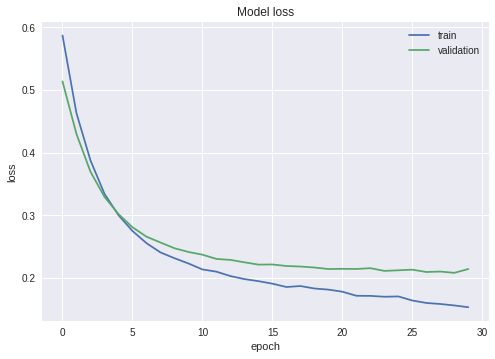

In [492]:
# The schema allows to see if the model was properly fitted
# that allows us to learn if the initial learning rate was appropriate
plt.title("Model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

### Treshold optimization
DISCLAIMER : Does not work as intended.

In that part we strive to optimize the treshold of activation of each label, in order to maximize F1 score

In [0]:
VOC = oneHotTransformer.vocabulary
tresholds = [0]*14
# Backup
def compute_f1_for_label(ilabel, treshold):
  prec, rec = 0, 0
  for (inputv, targetv) in test_loader:
    
    inputv = inputv.to(device)
    bounded_output = torch.sigmoid(model(inputv))

    labels_output = bounded_output[:, ilabel]
    #print(labels_output)
    pred_label = labels_output.data.gt(treshold)
    
    truth_label = targetv[:, ilabel]
    #print(ilabel, VOC[ilabel], "   \t", pred_label)
    #print("    expected\t", truth_label)
    # Confusion matrix
    tp = (pred_label + truth_label.data.to(device).byte()).eq(2).sum()
    fp = (pred_label - truth_label.data.to(device).byte()).eq(1).sum()
    fn = (pred_label - truth_label.data.to(device).byte()).eq(-1).sum()
    tn = (pred_label + truth_label.data.to(device).byte()).eq(0).sum()

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  prec /= len(test_loader)
  rec /= len(test_loader)
  if (prec+rec)==0:
    f1 = 0
  else: 
    f1 = 2*(prec*rec)/(prec+rec)
  return f1

In [493]:
def compute_f1_for_treshold(treshold):
  """
  Compute the f1 value for each label for a given treshold. It is an auxiliary
  function for optimizing the treshold for f1 value maximization.
  """
  prec = [0 for _ in range(14)]
  rec = [0 for _ in range(14)]
  f1 = [0 for _ in range(14)]
  for (inputv, targetv) in test_loader:
    
    inputv = inputv.to(device)
    bounded_output = torch.sigmoid(model(inputv))
    for ilabel in range(0, 14):
      labels_output = bounded_output[:, ilabel] # Non activated value
      pred_label = labels_output.data.gt(treshold) # Activation

      truth_label = targetv[:, ilabel]
      #print(ilabel, VOC[ilabel], "   \t", pred_label)
      #print("    expected\t", truth_label)
      # Confusion matrix
      tp = (pred_label + truth_label.data.to(device).byte()).eq(2).sum()
      fp = (pred_label - truth_label.data.to(device).byte()).eq(1).sum()
      fn = (pred_label - truth_label.data.to(device).byte()).eq(-1).sum()
      tn = (pred_label + truth_label.data.to(device).byte()).eq(0).sum()

      if tp+fp!=0:
        prec[ilabel] += tp.float() / (tp + fp)
      else:
        prec[ilabel] += 0.0
      if tp+fn != 0:
        rec[ilabel] += tp.float() / (tp + fn)
      else:
        rec[ilabel] += 0.0
  for ilabel in range(0, 14):
    prec[ilabel] /= len(test_loader)
    rec[ilabel] /= len(test_loader)
    if (prec[ilabel]+rec[ilabel])==0:
      f1[ilabel] = 0
    else: 
      f1tensor = 2*(prec[ilabel]*rec[ilabel])/(prec[ilabel]+rec[ilabel])
      f1[ilabel] = f1tensor.data.item()
  return np.array(f1)
compute_f1_for_treshold(0.1)

array([0.        , 0.13282248, 0.        , 0.2074074 , 0.46510217,
       0.        , 0.50250244, 0.        , 0.38280433, 0.        ,
       0.        , 0.70090216, 0.        , 0.        ])

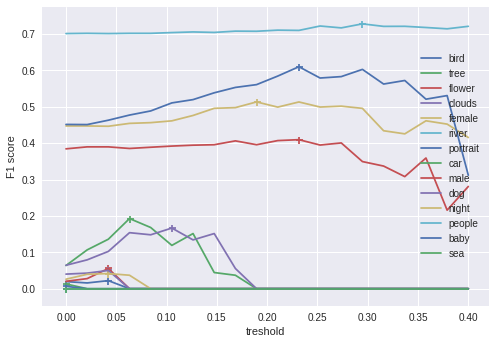

In [494]:
# Optimizing treshold for each label : Iterating over labels
# Dropout layers have the effect of making a network not returning the same output for a same output at different runs
# This means that F1 score function will be "noisy", ie it won't be a smooth curve.
# This makes optimization much more complicate than simply a SGD descent. To be tolerant of that case, 
# we check all values in order to not be tricked by noise, and choose the observed maximum.
class tresholdOptimizer():
  def __init__(self, paces=20, max=1): # High pace means more precision but slower computation
    wrapper = lambda array: [[elem] for elem in array]
    self.tresholds = np.linspace(0,max,paces)
    for t in self.tresholds:
      if t==0:
        self.tab = wrapper(compute_f1_for_treshold(t))
      else:
        aux = compute_f1_for_treshold(t)
        self.tab = np.hstack((self.tab, wrapper(aux)))
        
  def view(self):
    plt.xlabel("treshold")
    plt.ylabel("F1 score")
    for label in range(0,14):
      plt.plot(self.tresholds , self.tab[label], label=oneHotTransformer.vocabulary[label])
      imax = np.argmax(self.tab[label])
      plt.scatter(self.tresholds[imax], self.tab[label][imax], marker="+")
    plt.legend()
    plt.show()

  def get_best_tresholds(self):
    res = []
    for label in range(0,14):
      imax=np.argmax(self.tab[label])
      res.append(self.tresholds[imax])
    return res

treshold_opt = tresholdOptimizer()
treshold_opt.view()

In [508]:
def compute_model_stats(tresholds):
  """
  Returns precision, recall and f1 value for the given model.
  It needs tresholds to be previously defined, either arbitrarily or 
  by treshold optimization
  """
  prec = 0
  rec = 0
  acc = 0
  for (inputv, targetv) in test_loader:
    inputv = inputv.to(device)
    bounded_output = torch.sigmoid(model(inputv))
    pred_label = (bounded_output.data > tresholds) # Activation
    
    #print(tresholds)
    #print(bounded_output[:3])
    #print(pred_label[:3])
    
    #break
    tp = (pred_label + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred_label - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred_label - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred_label + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  try: f1 = 2*(prec*rec)/(prec+rec)
  except: f1 = 0
  return acc, prec, rec, f1

#best_tresholds = treshold_opt.get_best_tresholds() # Is actually not the best..!
#print(best_tresholds)

# CAREFUL! It appears that my implementation does not work. A constant treshold of 0.2
# appear to yield much better f1 than my implementation. Some fields are detected as performing best with 0, 
# with our optimizer which is wrong as shown below.
best_tresholds = [0.2, 0.3,
 0.2, 0.2,
 0.2, 0.2,
 0.2, 0.2,
 0.2, 0.2,
 0.2, 0.2,
 0.2, 0.2]
best_tresholds_as_tensor = torch.Tensor(best_tresholds).to(device) 
acc, prec, rec, f1 = compute_model_stats(best_tresholds_as_tensor)
print('Validation : Accuracy : {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            acc*100, prec*100, rec*100))
print("\t     F1 score : {:.2f}%\n".format(f1*100))

[0.042105263157894736, 0.06315789473684211, 0.042105263157894736, 0.10526315789473684, 0.18947368421052632, 0.0, 0.23157894736842105, 0.0, 0.23157894736842105, 0.042105263157894736, 0.042105263157894736, 0.29473684210526313, 0.0, 0.0]
Validation : Accuracy : 85.53%, Precision: 41.19%, Recall: 81.02%
	     F1 score : 54.62%



In [505]:
# Have a look at results
# So we can know what error is common
for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    #print("Prediction\n", output)
    tresholds = treshold_opt.get_best_tresholds()
    tresholds_as_tensor = torch.Tensor(tresholds).to(device) 
    pred = output.data.gt(tresholds_as_tensor) # Activated output
    print("Prediction\n", pred)
    print("Truth\n", targetv)
    break

Prediction
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.uint8)
Truth
 tensor([[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 

In [0]:
img_shape = {}
for current_img_path in all_img_paths:
    current_img_vector =  plt.imread( current_img_path )
    
    #if (str(str(current_img_vector.shape)) == "(128, 128)"):
    #    print(current_img_vector.shape, current_img_path)
    #    unicolor_name = current_img_path
    #    unicolor = current_img_vector
    if(str(current_img_vector.shape) not in img_shape.keys()):
        img_shape[str(current_img_vector.shape)] = []
    img_shape[str(current_img_vector.shape)].append(current_img_path)

In [0]:
img_shape.keys()

dict_keys(['(128, 128, 3)', '(128, 128)'])

RGB images

In [0]:
img_vector_3 = {}
#To process with all images, don't forget to remove "[:10]"
for current_img_path in img_shape["(128, 128, 3)"][:1024]:
    I =  plt.imread( current_img_path )
    modified_current_img_vector = np.array([I[:,:,0], I[:,:,1], I[:,:,2]])
    img_vector_3[current_img_path.split("/")[-1].split(".")[0].split("im")[-1]] = modified_current_img_vector


Grey images

In [0]:
img_vector_1 = {}

for current_img_path in img_shape["(128, 128)"]:
    current_img_vector =  plt.imread( current_img_path )
    #Do we have to reshape to (128*128) or (1,128*128) ?
    img_vector_1[current_img_path.split("/")[-1].split(".")[0].split("im")[-1]] = np.reshape(current_img_vector, (1,128,128))


In [0]:
nb_img_vector_3 = len(img_vector_3.keys())

Create train dataset and test dataset from 3 dimention images

In [0]:

batch_size = 64

img_names = rd.sample(list(img_vector_3.keys()), nb_img_vector_3)
train_img_name = img_names[ :int(nb_img_vector_3 * 0.8)]
test_img_name = img_names[ int(nb_img_vector_3 * 0.8):]


X_Train = torch.from_numpy(np.array([ [ img_vector_3[ train_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ] for id_name in range(int(len(train_img_name)/batch_size))]))
y_Train = torch.from_numpy(np.array([ [ img_labels[   train_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ]for id_name in range(int(len(train_img_name)/batch_size))]))

X_Test = torch.from_numpy(np.array([ [ img_vector_3[ test_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ] for id_name in range(int(len(test_img_name)/batch_size))]))
y_Test = torch.from_numpy(np.array([ [ img_labels[   test_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ]for id_name in range(int(len(test_img_name)/batch_size))]))

X_Train = X_Train.type('torch.FloatTensor')
y_Train = y_Train.type('torch.FloatTensor')
X_Test = X_Test.type('torch.FloatTensor')
y_Test = y_Test.type('torch.FloatTensor')


In [0]:
print(X_Train.shape)
print(y_Train.shape)
print(X_Test.shape)
print(y_Test.shape)

torch.Size([12, 64, 3, 128, 128])
torch.Size([12, 64, 14])
torch.Size([3, 64, 3, 128, 128])
torch.Size([3, 64, 14])


In [0]:
X_Test.shape

torch.Size([3, 64, 3, 128, 128])

In [0]:
X_Test[0].shape

torch.Size([64, 3, 128, 128])

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [0]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [0]:
np.savetxt('results.txt', y, fmt='%d')